# Descripcion del ejercicio

OBJETIVO: Predecir si el hay una pelea en un video

El conjunto de datos contiene videos en los cuales se incliyen ecenas de pelas. Se debe de construir un clasificador binario que etiquete correctamente los videos. 

El conjunto de datos probiene de Kaggle. https://www.kaggle.com/datasets/naveenk903/movies-fight-detection-dataset

INSTRUCCIONES.

* Analisis de datos: Caracteristicas de los conjuntos de datos: estadísticas sobre la duración de los videos video, relacion número de frames y etiqueta, etc . 

* Seleccion del modelo: Proponer la arquitectura, los hiperparametros y el tratamiendo de los modelos para el problema de clasificacion.

* Analisis de resultados: Inlcuir metricas como: F-measure, Precision, Recall

* Modelo: Guardar el modelo utilizando la libreria joblib.dump

# Breve investigacion en la literatura y foros sobre problemas similares

Para resolver ester problema en primera intancia realizo una búsqueda referentea trabajos similares. 

* Fight-Detection: Es una libreria para python que identifica peleas en tiempo real  haciendo uso del aprendizaje por transferencia en modelos 3D convolucionales previamente entrenados que tienen como objetivo reconocer los movimientos y acciones de los humanos. Todos los modelos utilizan el conjunto de datos Kinetics-400 para la parte preentrenada y el conjunto de datos de detección de peleas de cámaras de vigilancia basada en visión para la parte ajustada. Esta es la liga https://pypi.org/project/Fight-Detection/

* Fight detection using OpenCV: Esta es una propuesta o resultado que identifica una pelea utilizando la postura humana. Clasifica las posturas e identifica si la posocion correspoende a una postura de pelea. https://www.youtube.com/watch?v=TdqeDOv3QMQ

* Real-Time Violent Action Recognition Using Key Frames Extraction and Deep Learning. Este estudio explora la arquitectura de aprendizaje profundo de vanguardia de las redes neuronales convolucionales (CNN) y el inicio V4 para detectar y reconocer la violencia utilizando datos de video. Esta es la liga https://www.techscience.com/cmc/v69n2/43878/html

* Violence-Detection: El método consiste en extraer un conjunto de cuadros pertenecientes al video, enviarlos a una red preentrenada, obtener la salida de una de sus capas finales y a partir de estas salidas entrenar otra arquitectura de red con un tipo de neuronas especiales llamadas LSTM. Estas neuronas tienen memoria y son capaces de analizar la información temporal del video, si en algún momento detectan violencia, será catalogado como un video violento. Esta es la liga: https://www.kaggle.com/code/yassershrief/violence-detection-hockey-fight-cnn-lstm


# Pretratamiento de los datos y funciones auxiliares

En esta seccion se desarrolla la metodología para recorrer los directorios de videos, obtener sus frames y normalizar los datos para poder procesarlos y obtener sus caracteristicas mediante una red neuronal preentrenadoa. 

In [1]:
#Acceso al directorio al Drive donde se encuentran los videos del conjunto de datos
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Defino las rutas 
Path = '/content/gdrive/MyDrive/Entrevista/AVIVA'
Ruta_Peleas ='/content/gdrive/MyDrive/Entrevista/AVIVA/Peliculas/fights'
Ruta_NoPeleas = '/content/gdrive/MyDrive/Entrevista/AVIVA/Peliculas/noFights'

In [3]:
# Listo el total de videos de las carpetas
Files_fight = !ls -1 "{Ruta_Peleas}"
Files_no_fight = !ls -1 "{Ruta_NoPeleas}"

print("El total de videos de peleas es: ", len(Files_fight))
print("El total de videos de no peleas es: ", len(Files_no_fight))

El total de videos de peleas es:  100
El total de videos de no peleas es:  101


In [4]:
# Parametros de entrada de las imagenes
img_size = 224                             # Tamaño para redimencionar los frames de los video (224x244 es el tamño de entrada de la red VGG16)
num_channels = 3                           # Numero de canales

In [5]:
# Desarrollo una funcion que extraiga todos los frames del video y los normalice
import cv2
import numpy as np

# Funcion para extraer los frams de un video utilizando la ruta completa del video
def get_frames(Vid_Ruta):

  video = cv2.VideoCapture(Vid_Ruta)
  Frames = []
  while (video.isOpened()):
    ok_read, frame = video.read()
    if (ok_read == True):
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      frame = cv2.resize(frame, dsize=(img_size, img_size))   # Redimenciono la imagen
      Frames.append(frame)
      if (cv2.waitKey(30) == ord('s')):break
    else: break
  Frames = np.array(Frames)
  Frames = (Frames / 255.).astype(np.float32)                 # Normalizo los datos que sean menores que 1 y mayores que 0 
  return Frames

In [6]:
# Construyo una lista con todas las rutas de los videos y una lista con sus etiquetas
Video_paths = []
Etiquetas   = []

for vname in Files_fight:
  Video_paths.append(Ruta_Peleas + '/' + vname)
  Etiquetas.append(np.array([0]))                        # Etiqueta 0 indica PELEA

for vname in Files_no_fight:
  Video_paths.append(Ruta_NoPeleas + '/' + vname)
  Etiquetas.append(np.array([1]))                        # Etiqueta 1 idica No pelea

Video_paths = np.array(Video_paths)
Etiquetas   = np.array(Etiquetas)

# Obtencion de las Caracteristicas y Generacion de conjuntos para el entrenamiento

En esta seccion se utiliza una red neuronal Preentrenada para extraer las caracteristicas utilizando los valores de su ultima capa. En este caso se utilizara la red VGG16. Otras opciones pueden ser Resnet50 o EficcientB0 por ejemplo.

In [7]:
import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM

# Importo el modelo preentrenado VGG16
Modelo_VGG = VGG16(include_top=True, weights='imagenet')    # Cargo la RedVGG16 con los pesos preentrenados para el conjunto de imagenet

# efino mi modelo de extraccion de caracteristicas utilizando como salida la capa anterior a la de predicciones
Layer_Name = list(Modelo_VGG.layers)[-2].name
Features_Layer = Modelo_VGG.get_layer(Layer_Name)    
Features_Model = Model(inputs=Modelo_VGG.input,outputs=Features_Layer.output)

print("Procesar los frames y extraer sus caristicas mediante la red VGG16 implica que: ")
print("El input de cada framde tendra una dimencion de: ", Features_Model.input_shape[1:])
print("El ouput de cada frame tendra una dimencion de: ", Features_Model.output_shape[1])

Procesar los frames y extraer sus caristicas mediante la red VGG16 implica que: 
El input de cada framde tendra una dimencion de:  (224, 224, 3)
El ouput de cada frame tendra una dimencion de:  4096


In [8]:
# Obtengo las caracteristicas o patrones asociados a cada frame del video para cada uno de los videos
Caracteristicas = []
Fallos = []
for i in range(len(Video_paths)):
  try: Caracteristicas.append(Features_Model.predict(get_frames(Video_paths[i])))
  except:Fallos.append(i)
  if i % 20 == 0: print(i)

if (len(Fallos)>0): print("Hubo un fallo en los siguientes indices de video", print(Fallos))

0
20
40
60
80
100
120
140
160
180
200


In [9]:
# Identifico el video que contiene la mayor cantidad de frames
Max_Frames = 0
for vid in Caracteristicas:
  if vid.shape[0] > Max_Frames: Max_Frames = vid.shape[0]

# Estandarizo el tamaño de todos los Frames al mayor numero de frames
for pos in range(len(Caracteristicas)):
  if Caracteristicas[pos].shape[0] <60:
    dif = 60 - Caracteristicas[pos].shape[0]
    Caracteristicas[pos] = np.append(Caracteristicas[pos],Caracteristicas[pos][:dif],axis=0)

# NOTA: Se decidio realizar este procedimiento debido a que es preferible tener informacion repetida de los videos mas chicos en lugar de que recortar pedasos 
# de los videos mas grandes. No se sabe en que fragmentos de los videos se encuentre la secuencia de caracteristicas que definan un video de pelea

# Guardo el conjunto de caracteristicas obtenido procesado
Caracteristicas = np.array(Caracteristicas)
np.save(Path+'/Caracteristicas_Set.npy',Caracteristicas)
np.save(Path + '/Etiquetas_Set.npy',Etiquetas)

In [10]:
# Abro los conjuntos de datos
Caracteristicas = np.load(Path+'/Caracteristicas_Set.npy')
Etiquetas = np.load(Path + '/Etiquetas_Set.npy')

In [11]:
# Divido el conjunto de datos en train, valid y test
# NOTA: El 60% de los datos se utilizara como entrenamiento, el 20 % para validacion y el 20 % para test

np.random.seed(1)
Posiciones = np.random.permutation(len(Video_paths))                            #Barajeo las posiciones de los datos
Moises_Train, Moises_Valid = int(0.6*len(Etiquetas)), int(0.8*len(Etiquetas))   #Identifico los puntos donde se cortan los datos

# Constriyo los conjuntos con las posiciones aleatorias definiadas
Train_X = Caracteristicas[Posiciones[:Moises_Train]]
Train_Y = Etiquetas[Posiciones[:Moises_Train]]
Valid_X = Caracteristicas[Posiciones[Moises_Train:Moises_Valid]]
Valid_Y = Etiquetas[Posiciones[Moises_Train:Moises_Valid]]
Test_X = Caracteristicas[Posiciones[Moises_Valid:]]
Test_Y = Etiquetas[Posiciones[Moises_Valid:]]

# Construyo el modelo para la clasificacion de los datos

Para este modelo cabe destacar el uso de redes LSTM, las cuales son una buena opcion para identificar secuencias. 


In [12]:
import tensorflow as tf

# Esta funcion construye y entrena una red neuronal con los parametros de interes
def Obtain_Model(BS,LR,LSTMU,Epocas):

  tf.random.set_seed(1)
  
  # Se construye la arquietectura propuesta para la red neuronal
  Clasificador = Sequential()
  Clasificador.add(LSTM(LSTMU, input_shape=Train_X[0].shape))
  Clasificador.add(Dropout(0.5))
  Clasificador.add(Dense(512,activation='relu'))
  Clasificador.add(Dropout(0.5))
  Clasificador.add(Dense(50,activation='relu'))
  Clasificador.add(Dropout(0.5))
  Clasificador.add(Dense(1, activation='sigmoid'))             # Funcion Sigmodea debido a que es un problema de clasificacion Binario
  Clasificador.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=LR),metrics=['accuracy'])

  #Se entrena el modelo 
  Clasificador.fit(Train_X, Train_Y,
                   epochs=Epocas,
                   validation_data=(Valid_X, Valid_Y), 
                   batch_size=BS,
                  verbose=0)
  
  # Se regresa el modelo entrenado
  return Clasificador

In [13]:
# Propongo algunos valores a los parametros mas importantes para el diseño y entrenamiento del modelo de clasificacion 
Ba_Sizes = [8,16,32]             # Tamaños propuestos para el Batch size
LSTM_Un  = [256,512,1024]        # Numero de unidades en la primer capa LSTM
Le_Reates = [1e-3,1e-4,1e-5]     # Learning Rates propuestos para el entrenamiento
Epocas = 100  

# Obtengo todas las combinaciones de valores 
import itertools 
Combinaciones = list(itertools.product(Ba_Sizes,Le_Reates,LSTM_Un))

# Para cada una de las combinaciones (GRIDSEARCH) identifico el mejor modelo
Best_Comb = Combinaciones[0]

Scores = []
for comb in Combinaciones:
  Clasificador = Obtain_Model(comb[0],comb[1],comb[2],Epocas)  # BS,LR,LSTMU,Epocas
  Score_Valid = Clasificador.evaluate(Valid_X,Valid_Y)
  Score_Test  = Clasificador.evaluate(Test_X,Test_Y)
  Scores.append(np.array(  [float(Score_Valid[1]),float(Score_Test[1])]   ))
  print("ScoreValid: ",float(Score_Valid[1]), "ScoreTest: ",float(Score_Test[1]), comb)

Scores = np.array(Scores)

2/2 [==============================] - 0s 15ms/step - loss: 0.6950 - accuracy: 0.4634
ScoreValid:  0.5249999761581421 ScoreTest:  0.46341463923454285 (8, 0.001, 256)
2/2 [==============================] - 0s 21ms/step - loss: 0.6931 - accuracy: 0.5366
ScoreValid:  0.4749999940395355 ScoreTest:  0.5365853905677795 (8, 0.001, 512)
2/2 [==============================] - 0s 24ms/step - loss: 0.6932 - accuracy: 0.4634
ScoreValid:  0.5249999761581421 ScoreTest:  0.46341463923454285 (8, 0.001, 1024)
2/2 [==============================] - 0s 13ms/step - loss: 0.1173 - accuracy: 0.9756
ScoreValid:  0.9750000238418579 ScoreTest:  0.9756097793579102 (8, 0.0001, 256)
2/2 [==============================] - 0s 21ms/step - loss: 0.0314 - accuracy: 0.9756
ScoreValid:  0.949999988079071 ScoreTest:  0.9756097793579102 (8, 0.0001, 512)
2/2 [==============================] - 0s 33ms/step - loss: 0.0266 - accuracy: 1.0000
ScoreValid:  0.949999988079071 ScoreTest:  1.0 (8, 0.0001, 1024)
2/2 [===============

In [16]:
# Identifico la combinacion con la cual se obtuvieron los mejores resultados en la validacion y el test
Pos_Best_Com = np.argmax(Scores.sum(axis=1))
Best_Com = Combinaciones[Pos_Best_Com]

# Re entreno el modelo con estas combinaciones y lo guardo
Clasificador = Obtain_Model(Best_Com[0],Best_Com[1],Best_Com[2],Epocas)
Clasificador.save(Path + '/Clasificador_Pelea.h5')

import joblib
joblib.dump(Clasificador , Path + '/Clasificador_jlib')

# Revision de Resultados

A continuacion se revisan los resultados obtenidos por el modelo de clasifiacion realizado

In [17]:
print("Los parametros para el mejor modelo son: ")
print("Batch Size: ", Best_Com[0])
print("Learning Rate: ", Best_Com[1])
print("Unidades LSTM: ", Best_Com[2])
print("El rendimiento en el conjunto de Validacione es de: ", Scores[Pos_Best_Com][1])

Los parametros para el mejor modelo son: 
Batch Size:  8
Learning Rate:  1e-05
Unidades LSTM:  256
El rendimiento en el conjunto de Validacione es de:  1.0


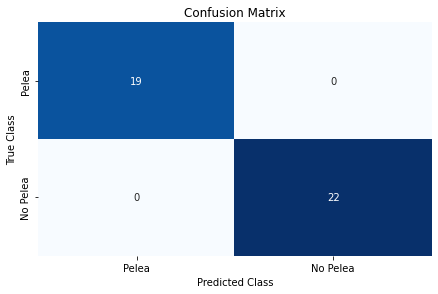

In [34]:
# Calculo y grafico la matriz de confuncion
from sklearn.metrics import confusion_matrix
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Proceso los datos de test reales y predecidps
Predecidos = Clasificador.predict(Test_X)
Predecidos = Predecidos.reshape(-1)
Pos_Zeros  = np.where(Predecidos<0.5)[0]
Pred_Test = np.ones(len(Predecidos))
Pred_Test[Pos_Zeros] = 0
Reales = Test_Y.reshape(-1)

# Calculo la matriz de confusion
Res_CM = confusion_matrix(Pred_Test,Reales)

# Grafico la matriz de confucion
dataframe = pd.DataFrame(Res_CM, index=['Pelea', 'No Pelea'], columns=['Pelea', 'No Pelea'])
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [40]:
# Metricas de medicion
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

Precision = precision_score(Pred_Test,Reales)
Recall   = recall_score(Pred_Test,Reales)
F1        = f1_score(Pred_Test,Reales)

print("A continuacion se introducen algunas metricas para analizar el comportamiento de clasificador")
print("Precision Score: ", Precision)
print("Recall Score: ", Recall)
print("F1 Score", F1)

A continuacion se introducen algunas metricas para analizar el comportamiento de clasificador
Precision Score:  1.0
Recall Score:  1.0
F1 Score 1.0


# Importancia de las caracteristicas

Aunado al modelo de clasificacion es posible generar un modelo que identifique las caracteristicas más importantes de los frames. Los resultados serian muy similares a los que se presentan en este video tutorial. https://www.youtube.com/watch?v=dw63QH_b3Jo. Para este problema de clasificacion, implementar este modelo nos ayudaria a identificar cuales son las caracteristicas o las secuencias sobre las que se basa el clasificador para identificar una pela. 

# Comentarios

Con base en los resultados obtenidos y a lo revisado en la investigación previa se resaltan las siguientes obervaciones:

* PRECISIÓN DEL MODELO: Se observó que el modelo clasifico exitosamente a todos los elementos del conjunto de Test. Esto puede deberse a que muchos videos son fragmentos de una misma pelicula. Cabe la posibilidad de que se aprendiera a identificar estos ecenarios en lugar de las características que definen a una pelea. Resulta importante revisar este punto para dar confiabilidad al modelo.  
* EXTENSIÓN DEL CONJUNTO DE VIDEOS: Es importante notar que el entrenamiento y la validacion se realizo utilizando un conjunto de modelos bastante rudido. Para extender la generalidad del modelo es necesario utilizar un conjunto de videos más diverso y extenso. 
* OTRAS REDES CNN: En caso de no obtener buenos resultados con la arquitectura planteada, se podrian revisar otras redes preentrenadas. Dentro de ellas destaco la posibilidad de usar alguna de la famila EFICCIENT, ya que han mostrado tener un muy buen desempeño en diferentes problemas.
* OTRAS REDES RECURRENTES: En caso de no tener buenos resultados con la arquitectura planteada, propondria utilizar una TCN para resolver este problema, ya que como su nombre lo indica, es una red convulucional temporal, la cual podria encontrar de mejor manera una solucion al problema. 
* DATA AUGMENTION: Debido a las caracteristicas del problema, es posible realizar aumentar el número de los videos aplicando operaciones a cada uno de los frames de los videos. De esta manera podriamos obtener un dataset mas nutrido para la extración y clasificación de características y secuencias. Esta propuesta tiene la desventaja de que también requere un uso más intensivo de recursos. 
* OTRO ENFOQUE: Otro enfoque para resolver este problema podría ser el uso de YOLO para identificar a cada una de las personas del video. Una vez identificadas se les podría aplicar el seguimiento de postura para vectorizar sus movimientos. Con estas secuencias de movimeintos podría entrenarse un clasificador.  Esta propuesta tiene la ventaja de reducir el tamaño de los inputs para el entrenamiento del modelo. Sin embargo aumenta la labor de preprocesamiento de los datos. 